# Testing CNN for imaging fluid flow with streaks analysis
    

## Prepatory steps

Get some includes first and define convenience routines

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py
import time
import torch
import math
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from numpy import random

%matplotlib inline

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cpu


Load data

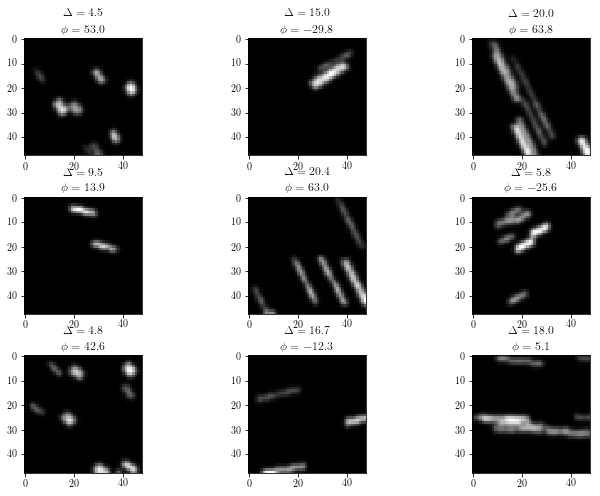

In [3]:
file_net = 'network_grayscale_gradient_uniformDisp_n=1M'

h5f = h5py.File(('networks/%s_data.h5' % file_net), 'r')

testImages = h5f['validationImages'][()]
testData = h5f['validationData'][()]
scale = h5f['scale'][()]
mean = h5f['mean'][()]
windowSize = h5f['windowSize'][()]
n_ensemble_members = h5f['n_ensemble_members'][()]
filter_size = h5f['filter_size'][()]
padding = h5f['padding'][()]
h5f.close()

indices = random.randint(0, len(testImages), 9)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig = plt.figure()
for i in range(indices.size):
    ax = fig.add_subplot(3, 3, i + 1)
    plt.gray()
    plt.imshow(testImages[indices[i],0,:,:])
    ax.set_title("$\Delta = %.1f$\n$\phi = %.1f$"  % (testData[indices[i],0], testData[indices[i],1]))
    
fig.set_size_inches(np.array(fig.get_size_inches()) * 2)
fig.subplots_adjust(hspace=0.35, wspace = 0.01)
plt.show()

Load trained networks into pytorch CNN acrhitecture. Note, the architecture that was used for training must be imported here.

In [4]:
from CNN_architectures import StreaksCNN

net_ensemble = []
for n in range(n_ensemble_members):
    f_output_name = 'networks/%s_%d.pytorch' % (file_net, n)
    net_ensemble.append(StreaksCNN(winSz = windowSize, \
                                   filtSz = filter_size, \
                                   convPad = padding))
    
    net_ensemble[n].load_state_dict(torch.load('networks/%s_%d.pytorch' % (file_net, n), map_location = device))
    net_ensemble[n].to(device)
    net_ensemble[n].eval()

n_params = sum(p.numel() for p in net_ensemble[0].parameters() if p.requires_grad)
print('Number of learnable parameters in the network:', n_params)

Number of learnable parameters in the network: 44370


Preprocess data

((250000, 2), (250000, 2))


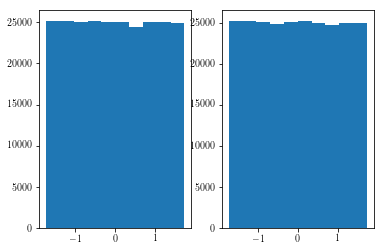

In [5]:
scaler = StandardScaler()
scaler.mean_ = mean
scaler.scale_ = scale

testDataUnit = scaler.transform(testData)

print((testData.shape, testData.shape))

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.hist(testDataUnit[:,0]);
ax = fig.add_subplot(1,2,2)
plt.hist(testDataUnit[:,1]);

## Apply CNN

Apply final network ensemble to the validation data set and check accuracy on Un and phi independently

In [6]:
params = {'batch_size': 192,
          'shuffle': False,
          'num_workers': 0}

xtest = torch.from_numpy(testImages / 255).type(torch.FloatTensor)
ytest = torch.from_numpy(testDataUnit).type(torch.FloatTensor)

test_dataset = TensorDataset(xtest, ytest)
test_loader = DataLoader(test_dataset, **params)

thrNorm = 2;
thrPhi = 18;

start_time = time.time()
yaveraged = np.zeros((len(test_dataset), 2))
yrmse = np.empty(shape=(0,2))
for n in range(n_ensemble_members):
    net = net_ensemble[n]
    net.eval()
    
    ypredicted = np.empty(shape=(0,2))
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
            
        # Forward pass
        net_outputs = net(inputs)
    
        if 'cuda' in device.type:
            net_outputs = net_outputs.cpu()
    
        ypredicted = np.concatenate((ypredicted, net_outputs.data.numpy()))
    
    ypredicted = scaler.inverse_transform(ypredicted)
    yresiduals = ypredicted - testData
    nrmse = np.sqrt(np.mean(yresiduals**2, axis = 0))
    yrmse = np.concatenate((yrmse, nrmse[np.newaxis, :]))

    #print(n, 'RMSE on Un = ', yrmse[0], ', RMSE on phi = ', yrmse[1])
 
    numCorrectNorm = np.sum(np.abs(yresiduals[:,0]) < thrNorm)
    numCorrectPhi = np.sum(np.abs(yresiduals[:,1]) < thrPhi)

    accuracy = np.array([numCorrectNorm, numCorrectPhi])/len(yresiduals)
    #print(n, 'Accuracy on Un =', accuracy[0]*100, '% and on phi =', accuracy[1]*100, '%')
    
    yaveraged += ypredicted
    
elapsed_time = time.time() - start_time
print("Testing finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, \
                            len(test_dataset) * n_ensemble_members / elapsed_time))
    
yaveraged /= n_ensemble_members
yresiduals = yaveraged - testData
ensemble_rmse = np.sqrt(np.mean(yresiduals**2, axis = 0))
print('Ensemble RMSE on Un = ', ensemble_rmse[0], ', RMSE on phi = ', ensemble_rmse[1])

Testing finished, took 479.9042s. 5209.37 images/sec.
Ensemble RMSE on Un =  1.0329033940549532 , RMSE on phi =  8.526886729785243


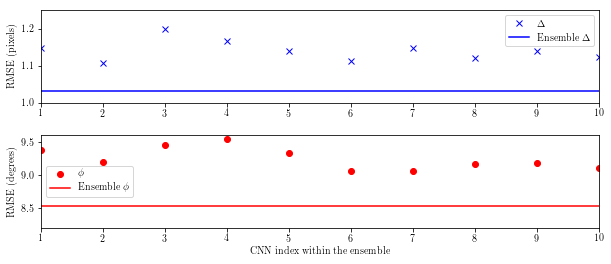

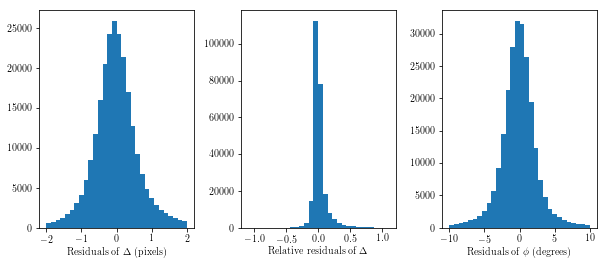

In [13]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(2,1,1)
ax.plot(np.arange(1, n_ensemble_members+1), yrmse[:,0], 'xb', label='$\Delta$');
ax.plot(np.array((0, 10)), np.ones((2,))*ensemble_rmse[0], '-b', label='Ensemble $\Delta$');
ax.set_ylabel('RMSE (pixels)')
plt.legend()
plt.xlim((1, n_ensemble_members));
plt.ylim((1, 1.25));
ax2 = fig.add_subplot(2,1,2)
ax2.plot(np.arange(1, n_ensemble_members+1), yrmse[:,1], 'or', label='$\phi$');
ax2.plot(np.array((0, 10)), np.ones((2,))*ensemble_rmse[1], '-r', label='Ensemble $\phi$');
ax2.set_ylabel('RMSE (degrees)')
ax2.set_xlabel('CNN index within the ensemble')
plt.legend()
plt.xlim((1, n_ensemble_members));
plt.ylim((8.2, 9.6));

fig.subplots_adjust(hspace=0.35, wspace = 0.3)
fig.savefig('paper/figs/figure2a.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)
plt.show()

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,3,1)
plt.hist(yresiduals[:,0], 30, (-2, 2));
plt.xlabel('Residuals of $\Delta$ (pixels)')
ax = fig.add_subplot(1,3,2)
plt.hist(yresiduals[:,0] / testData[:,0], 30, (-1.1, 1.1));
plt.xlabel('Relative residuals of $\Delta$')
ax = fig.add_subplot(1,3,3)
plt.hist(yresiduals[:,1], 30, (-10, 10));
plt.xlabel('Residuals of $\phi$ (degrees)')

fig.subplots_adjust(hspace=0.35, wspace = 0.3)
fig.savefig('paper/figs/figure2b.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)
plt.show()

Plot a few examples with predictions

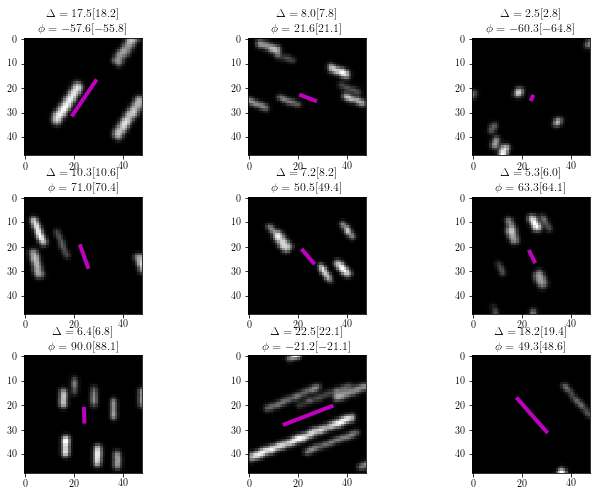

In [7]:
indices = random.randint(0, len(testImages), 9)

fig = plt.figure()
for i in range(indices.size):
    ax = fig.add_subplot(3, 3, i + 1)
    plt.gray()
    plt.imshow(testImages[indices[i],0,:,:])
    ax.set_title("$\Delta = %.1f [%.1f]$\n$\phi = %.1f [%.1f]$" \
                 % (testData[indices[i],0], yaveraged[indices[i],0], \
                    testData[indices[i],1], yaveraged[indices[i],1]))
    
    xc = windowSize / 2
    yc = windowSize / 2
    
    x0 = xc - math.cos(yaveraged[indices[i],1] * math.pi / 180) * yaveraged[indices[i],0] / 2.
    x1 = xc + math.cos(yaveraged[indices[i],1] * math.pi / 180) * yaveraged[indices[i],0] / 2.
    
    y0 = yc - math.sin(yaveraged[indices[i],1] * math.pi / 180) * yaveraged[indices[i],0] / 2.
    y1 = yc + math.sin(yaveraged[indices[i],1] * math.pi / 180) * yaveraged[indices[i],0] / 2.
    
    xy = np.array(([x0, y0], [x1, y1]));
    
    line = patches.Polygon(xy, color = 'm', linewidth = 4)
    
    ax.add_patch(line)
    
fig.set_size_inches(np.array(fig.get_size_inches()) * 2)
fig.subplots_adjust(hspace=0.35, wspace = 0.01)
fig.savefig('paper/figs/figure3.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)
plt.show()

Plot a few worst predictions

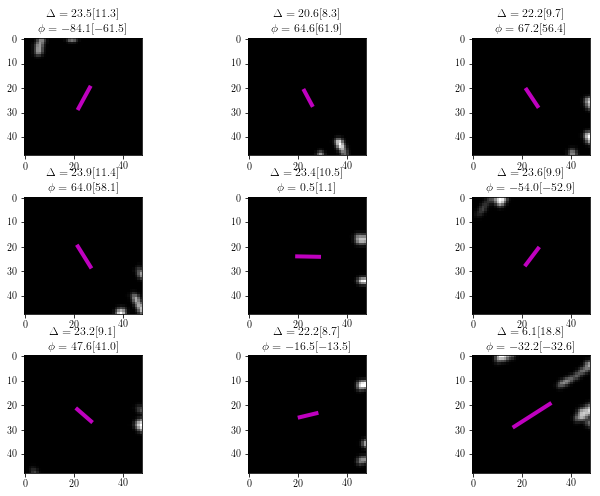

In [8]:
n_imgs = 9
indices = np.argpartition(np.abs(yresiduals[:,0]), -n_imgs)[-n_imgs:] # in displacement
#indices = np.argpartition(np.abs(yresiduals[:,1]), -n_imgs)[-n_imgs:] # in angle

fig = plt.figure()
for i in range(indices.size):
    ax = fig.add_subplot(3, 3, i + 1)
    plt.gray()
    plt.imshow(testImages[indices[i],0,:,:])
    ax.set_title("$\Delta = %.1f [%.1f]$\n$\phi = %.1f [%.1f]$" \
                 % (testData[indices[i],0], yaveraged[indices[i],0], \
                    testData[indices[i],1], yaveraged[indices[i],1]))
    
    xc = windowSize / 2
    yc = windowSize / 2
    
    x0 = xc - math.cos(yaveraged[indices[i],1] * math.pi / 180) * yaveraged[indices[i],0] / 2.
    x1 = xc + math.cos(yaveraged[indices[i],1] * math.pi / 180) * yaveraged[indices[i],0] / 2.
    
    y0 = yc - math.sin(yaveraged[indices[i],1] * math.pi / 180) * yaveraged[indices[i],0] / 2.
    y1 = yc + math.sin(yaveraged[indices[i],1] * math.pi / 180) * yaveraged[indices[i],0] / 2.
    
    xy = np.array(([x0, y0], [x1, y1]));
    
    line = patches.Polygon(xy, color = 'm', linewidth = 4)
    
    ax.add_patch(line)
    
fig.set_size_inches(np.array(fig.get_size_inches()) * 2)
fig.subplots_adjust(hspace=0.35, wspace = 0.01)
fig.savefig('paper/figs/figure4.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)
plt.show()